In [29]:
# Imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from utils import prepare_token_data, prepare_price_data
import api.address_constants as ac
from datetime import datetime
import matplotlib.dates as mdates

sns.set(style='whitegrid')

# Data paths
eETH_underlying_path = 'data/eETH/EETH-USD.csv'
etherfi_tvl_path = 'data/eETH/etherfi_tvl.csv'
etherfi_eETH_yt_jun_path = 'data/eETH/etherfi_eETH_Jun_yt_ohlcv_data.csv'
etherfi_eETH_pt_jun_path = 'data/eETH/etherfi_eETH_Jun_pt_ohlcv_data.csv'
etherfi_eETH_yt_sep_path = 'data/eETH/etherfi_eETH_Sep_yt_ohlcv_data.csv'
etherfi_eETH_pt_sep_path = 'data/eETH/etherfi_eETH_Sep_pt_ohlcv_data.csv'
etherfi_eETH_yt_dec_path = 'data/eETH/etherfi_eETH_Dec_yt_ohlcv_data.csv'
etherfi_eETH_pt_dec_path = 'data/eETH/etherfi_eETH_Dec_pt_ohlcv_data.csv'
zircuit_tvl_path = 'data/eETH/zircuit_tvl.csv'
zircuit_eETH_yt_jun_path = 'data/eETH/zircuit_eETH_Jun_yt_ohlcv_data.csv'
zircuit_eETH_pt_jun_path = 'data/eETH/zircuit_eETH_Jun_pt_ohlcv_data.csv'

ezETH_underlying_path = 'data/ezETH/EZETH-USD.csv'
renzo_tvl_path = 'data/ezETH/renzo_tvl.csv'
ezETH_yt_sep_path = 'data/ezETH/ezETH_Sep_yt_ohlcv_data.csv'
ezETH_pt_sep_path = 'data/ezETH/ezETH_Sep_pt_ohlcv_data.csv'
ezETH_yt_dec_path = 'data/ezETH/ezETH_Dec_yt_ohlcv_data.csv'
ezETH_pt_dec_path = 'data/ezETH/ezETH_Dec_pt_ohlcv_data.csv'

pufETH_underlying_path = 'data/pufETH/PUFETH-USD.csv'
puffer_tvl_path = 'data/pufETH/puffer_tvl.csv'
pufETH_yt_jun_path = 'data/pufETH/pufETH_Jun_yt_ohlcv_data.csv'
pufETH_pt_jun_path = 'data/pufETH/pufETH_Jun_pt_ohlcv_data.csv'
pufETH_yt_sep_path = 'data/pufETH/pufETH_Sep_yt_ohlcv_data.csv'
pufETH_pt_sep_path = 'data/pufETH/pufETH_Sep_pt_ohlcv_data.csv'

uniETH_underlying_path = 'data/uniETH/UNIETH-USD.csv'
bedrock_tvl_path = 'data/uniETH/bedrock_tvl.csv'
uniETH_yt_jun_path = 'data/uniETH/uniETH_Jun_yt_ohlcv_data.csv'
uniETH_pt_jun_path = 'data/uniETH/uniETH_Jun_pt_ohlcv_data.csv'
uniETH_yt_sep_path = 'data/uniETH/uniETH_Sep_yt_ohlcv_data.csv'
uniETH_pt_sep_path = 'data/uniETH/uniETH_Sep_pt_ohlcv_data.csv'

rsETH_underlying_path = 'data/rsETH/RSETH-USD.csv'
kelp_tvl_path = 'data/rsETH/kelp_tvl.csv'
rsETH_yt_jun_path = 'data/rsETH/rsETH_Jun_yt_ohlcv_data.csv'
rsETH_pt_jun_path = 'data/rsETH/rsETH_Jun_pt_ohlcv_data.csv'
rsETH_yt_sep_path = 'data/rsETH/rsETH_Sep_yt_ohlcv_data.csv'
rsETH_pt_sep_path = 'data/rsETH/rsETH_Sep_pt_ohlcv_data.csv'

# Load the data
etherfi_eETH_jun_df = prepare_token_data(eETH_underlying_path, etherfi_eETH_yt_jun_path, etherfi_eETH_pt_jun_path, ac.etherfi_eETH_Jun_start_date, ac.expiry_date_jun, etherfi_tvl_path)
etherfi_eETH_sep_df = prepare_token_data(eETH_underlying_path, etherfi_eETH_yt_sep_path, etherfi_eETH_pt_sep_path, ac.etherfi_eETH_Sep_start_date, ac.expiry_date_sep, etherfi_tvl_path)
etherfi_eETH_dec_df = prepare_token_data(eETH_underlying_path, etherfi_eETH_yt_dec_path, etherfi_eETH_pt_dec_path, ac.etherfi_eETH_Dec_start_date, ac.expiry_date_dec, etherfi_tvl_path)
zircuit_eETH_jun_df = prepare_token_data(eETH_underlying_path, zircuit_eETH_yt_jun_path, zircuit_eETH_pt_jun_path, ac.zircuit_eETH_Jun_start_date, ac.expiry_date_jun, zircuit_tvl_path)

ezETH_sep_df = prepare_token_data(ezETH_underlying_path, ezETH_yt_sep_path, ezETH_pt_sep_path, ac.ezETH_Sep_start_date, ac.expiry_date_sep, renzo_tvl_path)
ezETH_dec_df = prepare_token_data(ezETH_underlying_path, ezETH_yt_dec_path, ezETH_pt_dec_path, ac.ezETH_Dec_start_date, ac.expiry_date_dec, renzo_tvl_path)

pufETH_jun_df = prepare_token_data(pufETH_underlying_path, pufETH_yt_jun_path, pufETH_pt_jun_path, ac.pufETH_Jun_start_date, ac.expiry_date_jun, puffer_tvl_path)
pufETH_sep_df = prepare_token_data(pufETH_underlying_path, pufETH_yt_sep_path, pufETH_pt_sep_path, ac.pufETH_Sep_start_date, ac.expiry_date_sep, puffer_tvl_path)

uniETH_jun_df = prepare_token_data(uniETH_underlying_path, uniETH_yt_jun_path, uniETH_pt_jun_path, ac.uniETH_Jun_start_date, ac.expiry_date_jun, bedrock_tvl_path)
uniETH_sep_df = prepare_token_data(uniETH_underlying_path, uniETH_yt_sep_path, uniETH_pt_sep_path, ac.uniETH_Sep_start_date, ac.expiry_date_sep, bedrock_tvl_path)

rsETH_jun_df = prepare_token_data(rsETH_underlying_path, rsETH_yt_jun_path, rsETH_pt_jun_path, ac.rsETH_Jun_start_date, ac.expiry_date_jun, kelp_tvl_path)
rsETH_sep_df = prepare_token_data(rsETH_underlying_path, rsETH_yt_sep_path, rsETH_pt_sep_path, ac.rsETH_Sep_start_date, ac.expiry_date_sep, kelp_tvl_path)

tokens = {
    'etherfi_eETH': {'Jun': etherfi_eETH_jun_df, 'Sep': etherfi_eETH_sep_df, 'Dec': etherfi_eETH_dec_df},
    'zircuit_eETH': {'Jun': zircuit_eETH_jun_df},
    'ezETH': {'Sep': ezETH_sep_df, 'Dec': ezETH_dec_df},
    'pufETH': {'Jun': pufETH_jun_df, 'Sep': pufETH_sep_df},
    'uniETH': {'Jun': uniETH_jun_df, 'Sep': uniETH_sep_df},
    'rsETH': {'Jun': rsETH_jun_df, 'Sep': rsETH_sep_df}
}

# Flatten the dictionary and prepare DataFrames for concatenation
dfs = []
for token_name, maturities in tokens.items():
    for maturity, df in maturities.items():
        # Ensure the date is the DataFrame index if not already
        if 'date' in df.columns:
            df.set_index('date', inplace=True)

        # Rename columns to include token and maturity information for uniqueness
        df.columns = [f"{token_name}_{maturity}_{col}" for col in df.columns]
        dfs.append(df)

# Concatenate all DataFrames on the date index
combined_df = pd.concat(dfs, axis=1)
combined_df.sort_index(inplace=True)

etherfi_eETH_jun_df = prepare_token_data(eETH_underlying_path, etherfi_eETH_yt_jun_path, etherfi_eETH_pt_jun_path, ac.etherfi_eETH_Jun_start_date, ac.expiry_date_jun, etherfi_tvl_path)
etherfi_eETH_sep_df = prepare_token_data(eETH_underlying_path, etherfi_eETH_yt_sep_path, etherfi_eETH_pt_sep_path, ac.etherfi_eETH_Sep_start_date, ac.expiry_date_sep, etherfi_tvl_path)
etherfi_eETH_dec_df = prepare_token_data(eETH_underlying_path, etherfi_eETH_yt_dec_path, etherfi_eETH_pt_dec_path, ac.etherfi_eETH_Dec_start_date, ac.expiry_date_dec, etherfi_tvl_path)
zircuit_eETH_jun_df = prepare_token_data(eETH_underlying_path, zircuit_eETH_yt_jun_path, zircuit_eETH_pt_jun_path, ac.zircuit_eETH_Jun_start_date, ac.expiry_date_jun, zircuit_tvl_path)

ezETH_sep_df = prepare_token_data(ezETH_underlying_path, ezETH_yt_sep_path, ezETH_pt_sep_path, ac.ezETH_Sep_start_date, ac.expiry_date_sep, renzo_tvl_path)
ezETH_dec_df = prepare_token_data(ezETH_underlying_path, ezETH_yt_dec_path, ezETH_pt_dec_path, ac.ezETH_Dec_start_date, ac.expiry_date_dec, renzo_tvl_path)

pufETH_jun_df = prepare_token_data(pufETH_underlying_path, pufETH_yt_jun_path, pufETH_pt_jun_path, ac.pufETH_Jun_start_date, ac.expiry_date_jun, puffer_tvl_path)
pufETH_sep_df = prepare_token_data(pufETH_underlying_path, pufETH_yt_sep_path, pufETH_pt_sep_path, ac.pufETH_Sep_start_date, ac.expiry_date_sep, puffer_tvl_path)

uniETH_jun_df = prepare_token_data(uniETH_underlying_path, uniETH_yt_jun_path, uniETH_pt_jun_path, ac.uniETH_Jun_start_date, ac.expiry_date_jun, bedrock_tvl_path)
uniETH_sep_df = prepare_token_data(uniETH_underlying_path, uniETH_yt_sep_path, uniETH_pt_sep_path, ac.uniETH_Sep_start_date, ac.expiry_date_sep, bedrock_tvl_path)

rsETH_jun_df = prepare_token_data(rsETH_underlying_path, rsETH_yt_jun_path, rsETH_pt_jun_path, ac.rsETH_Jun_start_date, ac.expiry_date_jun, kelp_tvl_path)
rsETH_sep_df = prepare_token_data(rsETH_underlying_path, rsETH_yt_sep_path, rsETH_pt_sep_path, ac.rsETH_Sep_start_date, ac.expiry_date_sep, kelp_tvl_path)

In [30]:
from abc import ABC, abstractmethod

class Asset:
    def __init__(self):
        self.position = 0
        self.current_price = 0
        self.unrealized_gain = 0
        self.realized_gain = 0

    def update_price(self, new_price):
        # Only update unrealized gains if there is an existing position
        if self.position != 0:
            price_diff = new_price - self.current_price
            self.unrealized_gain += self.position * price_diff
        self.current_price = new_price

    def execute_trade(self, delta_position):
        # Executing trade changes the position but does not affect gains
        self.position += delta_position

    def get_total_gain(self):
        return self.unrealized_gain + self.realized_gain

class YieldToken(Asset):
    def update_daily_gain(self, daily_yield_rate, fee_rate=0.0003):
        # Apply daily gain based on the current position and price
        self.unrealized_gain += (1 - fee_rate) * self.position * daily_yield_rate * self.current_price

class PrincipalToken(Asset):
    def __init__(self):
        super().__init__()

    def liquidate(self, liquidation_price):
        self.realized_gain += max(self.position * (liquidation_price - self.current_price), 0)
        self.position = 0

class Strategy(ABC):
    @abstractmethod
    def trade(self, prices_df, current_index, underlying_pos, pt_pos, yt_pos, name=None):
        return (0, 0, 0)

def apply_strategy_to_all(strategy):
    return {
    'etherfi_jun': {'data': etherfi_eETH_jun_df, 'strategy': strategy},
    'etherfi_sep': {'data': etherfi_eETH_sep_df, 'strategy': strategy},
    'etherfi_dec': {'data': etherfi_eETH_dec_df, 'strategy': strategy},
    'zircuit_jun': {'data': zircuit_eETH_jun_df, 'strategy': strategy},
    'ezETH_sep': {'data': ezETH_sep_df, 'strategy': strategy},
    'ezETH_dec': {'data': ezETH_dec_df, 'strategy': strategy},
    'pufETH_jun': {'data': pufETH_jun_df, 'strategy': strategy},
    'pufETH_sep': {'data': pufETH_sep_df, 'strategy': strategy},
    'uniETH_jun': {'data': uniETH_jun_df, 'strategy': strategy},
    'uniETH_sep': {'data': uniETH_sep_df, 'strategy': strategy},
    'rsETH_jun': {'data': rsETH_jun_df, 'strategy': strategy},
    'rsETH_sep': {'data': rsETH_sep_df, 'strategy': strategy}
    }

def apply_strategy_to_all_jun(strategy):
    return {
    'etherfi_jun': {'data': etherfi_eETH_jun_df, 'strategy': strategy},
    'zircuit_jun': {'data': zircuit_eETH_jun_df, 'strategy': strategy},
    'pufETH_jun': {'data': pufETH_jun_df, 'strategy': strategy},
    'uniETH_jun': {'data': uniETH_jun_df, 'strategy': strategy},
    'rsETH_jun': {'data': rsETH_jun_df, 'strategy': strategy}
    }

In [31]:
class PendleBacktest:
    def __init__(self, assets_strategies, isJune=False):
        self.assets = {
            name: {
                'data': asset['data'],
                'tokens': {
                    'underlying': Asset(),
                    'pt': PrincipalToken(),
                    'yt': YieldToken()
                },
                'strategy': asset['strategy']
            } for name, asset in assets_strategies.items()
        }
        min_date = min(asset['data'].index.min() for asset in self.assets.values())
        max_date = max(asset['data'].index.max() for asset in self.assets.values())
        self.overall_cumulative_profit = pd.Series(0, index=pd.date_range(start=min_date, end=max_date))
        self.isJune = isJune

    def trade(self):
        for name, asset in self.assets.items():
            df = asset['data']
            tokens = asset['tokens']
            strategy = asset['strategy']
            cumulative_profit = 0

            for index, current_prices in df.iterrows():
                # Update prices first, then trade
                tokens['underlying'].update_price(current_prices['underlying_open'])
                tokens['pt'].update_price(current_prices['pt_open'])
                tokens['yt'].update_price(current_prices['yt_open'])

                # Execute trades based on the strategy
                deltas = strategy.trade(df, index, tokens['underlying'].position, tokens['pt'].position, tokens['yt'].position, name=name)

                # Minting and Burning Arbitrage
                try:
                    if deltas[3] == True: # Make PT + YT - underlying profit
                        tokens['pt'].realized_gain += 0.009 * current_prices['pt_open']
                        tokens['yt'].realized_gain += 0.009 * current_prices['yt_open']
                        tokens['underlying'].realized_gain -= 0.01 * current_prices['underlying_open']
                    elif deltas[4] == True: # Make underlying - PT - YT profit
                        tokens['pt'].realized_gain -= 0.01 * current_prices['pt_open']
                        tokens['yt'].realized_gain -= 0.01 * current_prices['yt_open']
                        tokens['underlying'].realized_gain += 0.009 * current_prices['underlying_open']
                except:
                    # Execute trades without affecting profit directly
                    tokens['underlying'].execute_trade(deltas[0])
                    tokens['pt'].execute_trade(deltas[1])
                    tokens['yt'].execute_trade(deltas[2])

                # Update daily yield for yield token
                if tokens['yt'].position != 0:
                    daily_yield_rate = ((1 + df.at[index, 'implied_apy']) ** (1/365) - 1)
                    tokens['yt'].update_daily_gain(daily_yield_rate)

                # Liquidate PT if it is the last day of the month (for June contracts)
                if df.loc[index, 'days_to_expiry'] == 1 and self.isJune:
                    tokens['pt'].liquidate(current_prices['underlying_open'])

                # Aggregate profit updates
                cumulative_profit = sum([token.get_total_gain() for token in tokens.values()])
                df.at[index, 'cumulative_profit'] = cumulative_profit

            self.overall_cumulative_profit[df.index] += df['cumulative_profit']

        return self.overall_cumulative_profit

    def plot_profit(self, isHedged=False, includeLast=False):
        cumulative_profit = self.trade()
        cumulative_profit = cumulative_profit.dropna()
        if not includeLast: # This is due to a last day data issue where prices are 0
            cumulative_profit = cumulative_profit[:-1]
        cumulative_profit_plot = cumulative_profit.copy()

        first_non_zero_index = cumulative_profit.ne(0).idxmax()
        cumulative_profit = cumulative_profit.loc[first_non_zero_index:]

        annual_rfr = 0.05
        daily_rfr = (1 + annual_rfr) ** (1 / 365) - 1

        # Calculate profit
        print("Profit: {:.2f}".format(cumulative_profit[-1]))

        # Calculate Sharpe ratio
        returns = np.log(cumulative_profit + 1) - np.log(cumulative_profit.shift(1) + 1)
        returns_cleaned = returns.replace([np.inf, -np.inf], np.nan).dropna()
        if returns_cleaned.std() != 0:
            sharpe_ratio = ((returns_cleaned.mean() - daily_rfr) / returns_cleaned.std()) * np.sqrt(365)
        else:
            sharpe_ratio = float('nan')
        print("Sharpe Ratio: {:.2f}".format(sharpe_ratio))

        # Calculate Sortino ratio
        sortino_ratio = ((returns_cleaned.mean() - daily_rfr) / returns_cleaned[returns_cleaned < 0].std()) * np.sqrt(365)
        print("Sortino Ratio: {:.2f}".format(sortino_ratio))

        print("Daily returns: " + str(returns_cleaned.mean()))

        # Plot cumulative profit
        fig, ax = plt.subplots(figsize=(10, 6))
        cumulative_profit_plot.plot(ax=ax)
        ax.set_title('Cumulative Profit Over Time' + (' (ETH)' if isHedged else ' (USD)'), fontsize=16)
        ax.set_ylabel('Profit', fontsize=16)

        plt.xticks(fontsize=16)
        plt.yticks(fontsize=14)

        plt.gca().xaxis.set_major_locator(mdates.MonthLocator())
        plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
        plt.tight_layout()
        plt.show()

In [32]:
class PendleHedgedBacktest(PendleBacktest):
    def __init__(self, assets_strategies, isJune=False):
        super().__init__(assets_strategies, isJune)

    def trade(self):
        for name, asset in self.assets.items():
            df = asset['data']
            tokens = asset['tokens']
            strategy = asset['strategy']
            cumulative_profit = 0

            for index, current_prices in df.iterrows():
                # Update prices first, then trade
                tokens['pt'].update_price(current_prices['pt_open_eth'])
                tokens['yt'].update_price(current_prices['yt_open_eth'])
                tokens['underlying'].update_price(1)

                deltas = strategy.trade(df, index, 0, tokens['pt'].position, tokens['yt'].position, name=name)

                # Minting and Burning Arbitrage
                try:
                    # assume 0.01 eth is used for each time to minimize the impact of slippage
                    if deltas[3] == True: # Make PT + YT - underlying profit
                        tokens['pt'].realized_gain += 0.009 * current_prices['pt_open_eth']
                        tokens['yt'].realized_gain += 0.009 * current_prices['yt_open_eth']
                        tokens['underlying'].realized_gain - 0.01
                    elif deltas[4] == True: # Make underlying - PT - YT profit
                        tokens['pt'].realized_gain -= 0.01 * current_prices['pt_open_eth']
                        tokens['yt'].realized_gain -= 0.01 * current_prices['yt_open_eth']
                        tokens['underlying'].realized_gain += 0.009
                except:
                    # Execute trades without affecting profit directly
                    # Strategies can either return (_, pt, yt) or (pt, yt). This makes non-hedged strategies compatible.
                    try:
                        tokens['yt'].execute_trade(deltas[2])
                        tokens['pt'].execute_trade(deltas[1])
                        tokens['underlying'].execute_trade(deltas[0])
                    except:
                        tokens['yt'].execute_trade(deltas[1])
                        tokens['pt'].execute_trade(deltas[0])

                # Update daily yield for yield token
                if tokens['yt'].position != 0:
                    daily_yield_rate = ((1 + df.at[index, 'implied_apy']) ** (1/365) - 1)
                    tokens['yt'].update_daily_gain(daily_yield_rate)

                # Liquidate principal token if it is the last day
                if df.loc[index, 'days_to_expiry'] == 1 and self.isJune:
                    tokens['pt'].liquidate(1)

                # Aggregate profit updates
                cumulative_profit = sum([token.get_total_gain() for token in tokens.values()])
                df.at[index, 'cumulative_profit'] = cumulative_profit

            self.overall_cumulative_profit += df['cumulative_profit']

        return self.overall_cumulative_profit.fillna(0)

    def plot_profit(self, includeLast=False):
        super().plot_profit(isHedged=True, includeLast=includeLast)

In [33]:
# Signals for basket strategies
def generate_feature_and_vol_signals(feature_df, vol_df, n=3):
    signals_df = pd.DataFrame(index=feature_df.index)
    for date, row in feature_df.iterrows():
        features = row.dropna()
        vols = vol_df.loc[date].dropna()
        combined = pd.DataFrame({'feature': features, 'vol': vols})
        combined['vol_rank'] = combined['vol'].rank(method='min')  # Lower volatility is better
        combined['feature_rank'] = combined['feature'].rank(ascending=False, method='min')  # Higher feature is better
        combined['score'] = combined['feature_rank'] - combined['vol_rank'] # Simple score to balance feature growth and low volatility

        sorted_tokens = combined.sort_values(by='score', ascending=False).index.tolist()
        if len(sorted_tokens) >= 2 * n:
            for token in sorted_tokens[:n]:  # Buy signal for top n
                signals_df.at[date, token] = 1
            for token in sorted_tokens[-n:]:  # Short signal for bottom n
                signals_df.at[date, token] = -1
    return signals_df.fillna(0)

def get_data_dict(col_name):
    return {
        'etherfi_jun': etherfi_eETH_jun_df[col_name],
        'etherfi_sep': etherfi_eETH_sep_df[col_name],
        'etherfi_dec': etherfi_eETH_dec_df[col_name],
        'zircuit_jun': zircuit_eETH_jun_df[col_name],
        'ezETH_sep': ezETH_sep_df[col_name],
        'ezETH_dec': ezETH_dec_df[col_name],
        'pufETH_jun': pufETH_jun_df[col_name],
        'pufETH_sep': pufETH_sep_df[col_name],
        'uniETH_jun': uniETH_jun_df[col_name],
        'uniETH_sep': uniETH_sep_df[col_name],
        'rsETH_jun': rsETH_jun_df[col_name],
        'rsETH_sep': rsETH_sep_df[col_name]
    }

### Same underlying, different duration

In [34]:
# class DurationLongStrategy(Strategy):
#     def trade(self, prices_df, current_index, underlying_pos, pt_pos, yt_pos, name=None):
#         current_row = prices_df.loc[current_index]
#         days_to_expiry = current_row['days_to_expiry']
#         return (0, -1, 0)

# class DurationShortStrategy(Strategy):
#     def trade(self, prices_df, current_index, underlying_pos, pt_pos, yt_pos, name=None):
#         current_row = prices_df.loc[current_index]
#         days_to_expiry = current_row['days_to_expiry']
#         return (0, 1, 0)

# assets_strategies_list_pairs = [
#     {
#         'etherfi_jun': {'data': etherfi_eETH_jun_df, 'strategy': DurationShortStrategy()},
#         'etherfi_dec': {'data': etherfi_eETH_dec_df, 'strategy': DurationLongStrategy()}
#     },
#     {
#         'pufETH_jun': {'data': pufETH_jun_df, 'strategy': DurationShortStrategy()},
#         'pufETH_sep': {'data': pufETH_sep_df, 'strategy': DurationLongStrategy()}
#     },
#     {
#         'etherfi_jun': {'data': etherfi_eETH_jun_df, 'strategy': DurationShortStrategy()},
#         'etherfi_sep': {'data': etherfi_eETH_sep_df, 'strategy': DurationLongStrategy()},
#     },
#     {
#         'rsETH_jun': {'data': rsETH_jun_df, 'strategy': DurationShortStrategy()},
#         'rsETH_sep': {'data': rsETH_sep_df, 'strategy': DurationLongStrategy()}
#     }
# ]

# custom_labels = [
#     'Etherfi eETH Jun/Dec',
#     'pufETH Jun/Sep',
#     'Etherfi eETH Jun/Sep',
#     'rsETH Jun/Sep'
# ]

# # Prepare a figure for plotting
# fig, ax = plt.subplots(figsize=(10, 6))

# # Iterate through each set of asset strategies, backtest them, and plot their cumulative profits
# for i, assets_strategies in enumerate(assets_strategies_list_pairs):
#     start_date = max(asset['data'].index.min() for asset in assets_strategies.values())

#     # Truncate the dataframes to start from the found start_date
#     for asset in assets_strategies.values():
#         asset['data'] = asset['data'][asset['data'].index >= start_date]

#     backtest = PendleBacktest(assets_strategies)
#     cumulative_profit = backtest.trade().dropna()
#     cumulative_profit = cumulative_profit[:-1]

#     # Use the custom label for each line plot
#     cumulative_profit.plot(ax=ax, label=custom_labels[i])

# ax.set_title('Cumulative Profit Over Time (ETH)')
# ax.set_ylabel('Cumulative Profit')
# ax.set_xlabel('Date')
# plt.legend()
# plt.show()

# # Prepare a figure for plotting
# fig, ax = plt.subplots(figsize=(10, 6))

# # Iterate through each set of asset strategies, backtest them, and plot their cumulative profits
# for i, assets_strategies in enumerate(assets_strategies_list_pairs):
#     start_date = max(asset['data'].index.min() for asset in assets_strategies.values())

#     # Truncate the dataframes to start from the found start_date
#     for asset in assets_strategies.values():
#         asset['data'] = asset['data'][asset['data'].index >= start_date]

#     backtest = PendleHedgedBacktest(assets_strategies)
#     cumulative_profit = backtest.trade().dropna()
#     cumulative_profit = cumulative_profit[:-1]

#     # Use the custom label for each line plot
#     cumulative_profit.plot(ax=ax, label=custom_labels[i])

# ax.set_title('Cumulative Profit Over Time (ETH)')
# ax.set_ylabel('Cumulative Profit')
# ax.set_xlabel('Date')
# plt.legend()
# plt.show()

# for i, assets_strategies in enumerate(assets_strategies_list_pairs):
#     backtest = PendleHedgedBacktest(assets_strategies)
#     print(custom_labels[i])
#     backtest.plot_profit()

#     # Use the custom label for each line plot
#     cumulative_profit.plot(ax=ax, label=custom_labels[i])

### Same underlying, different protocol

C:\Users\faris\AppData\Local\Temp\ipykernel_18040\4247852888.py:62: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.at[index, 'cumulative_profit'] = cumulative_profit
c:\Python310\lib\site-packages\pandas\core\arraylike.py:396: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


Profit: 3254.86
Sharpe Ratio: 2.62
Sortino Ratio: 3.88
Daily returns: 0.03492883063051529


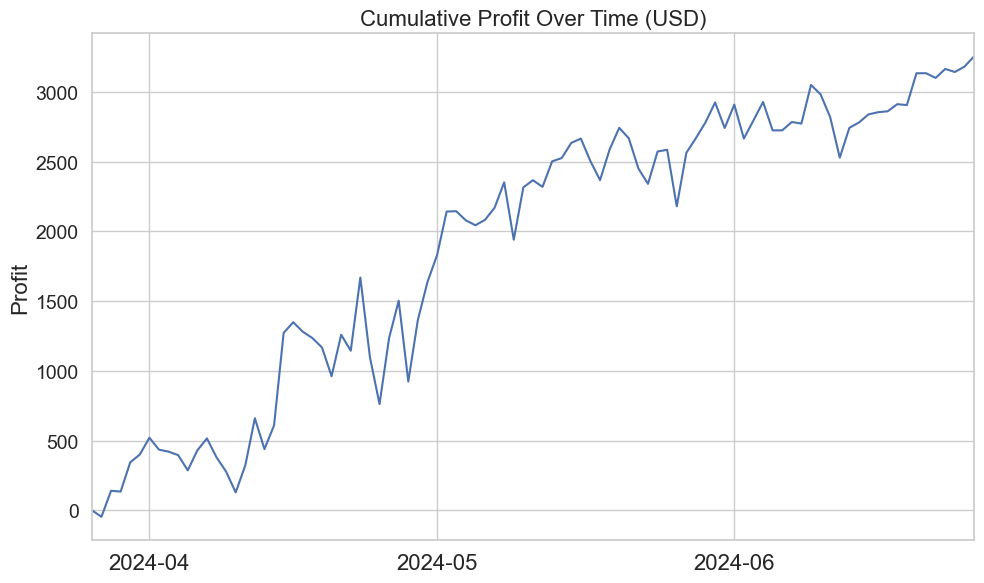

Profit: 0.97
Sharpe Ratio: 2.94
Sortino Ratio: 4.24
Daily returns: 0.007588016171859627


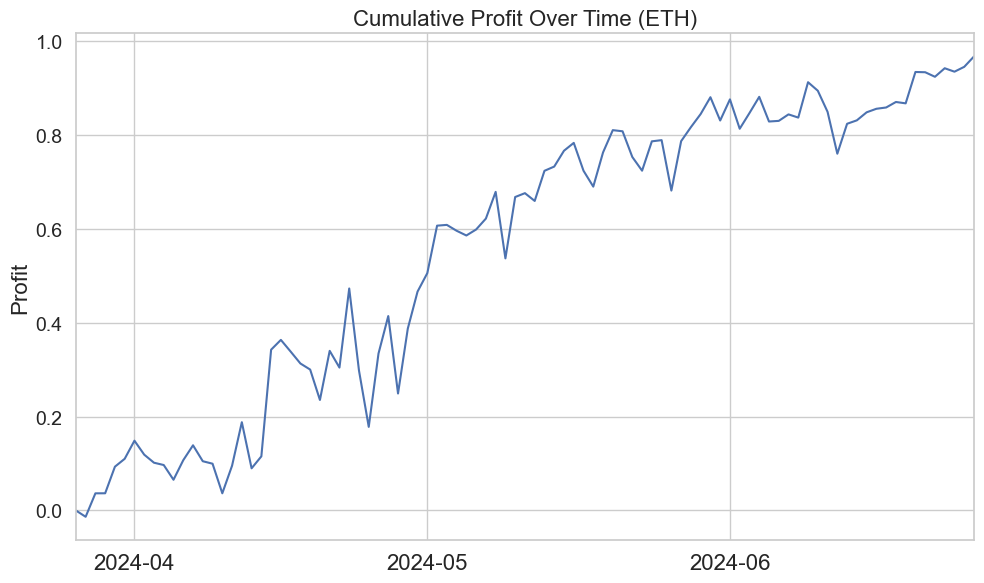

In [35]:
class DurationLongStrategy(Strategy):
    def trade(self, prices_df, current_index, underlying_pos, pt_pos, yt_pos, name=None):
        current_row = prices_df.loc[current_index]
        days_to_expiry = current_row['days_to_expiry']
        return (0, 1, 0)

class DurationShortStrategy(Strategy):
    def trade(self, prices_df, current_index, underlying_pos, pt_pos, yt_pos, name=None):
        current_row = prices_df.loc[current_index]
        days_to_expiry = current_row['days_to_expiry']
        return (0, -1, 0)

start_date = max(etherfi_eETH_jun_df.index.min(), zircuit_eETH_jun_df.index.min())

# Truncate etherfi_eETH_jun_df to start from the found start_date
etherfi_eETH_jun_df_truncated = etherfi_eETH_jun_df[etherfi_eETH_jun_df.index >= start_date]

assets_strategies = {
    'etherfi_jun': {'data': etherfi_eETH_jun_df_truncated, 'strategy': DurationShortStrategy()},
    'zircuit_jun': {'data': zircuit_eETH_jun_df, 'strategy': DurationLongStrategy()}
}

# Iterate through each set of asset strategies, backtest them, and plot their cumulative profits
backtest = PendleBacktest(assets_strategies)
backtest.plot_profit()

backtest = PendleHedgedBacktest(assets_strategies)
backtest.plot_profit()

### High Fixed Yields

Profit: 4.91
Sharpe Ratio: 3.63
Sortino Ratio: 6.54
Daily returns: 0.017941297455557687


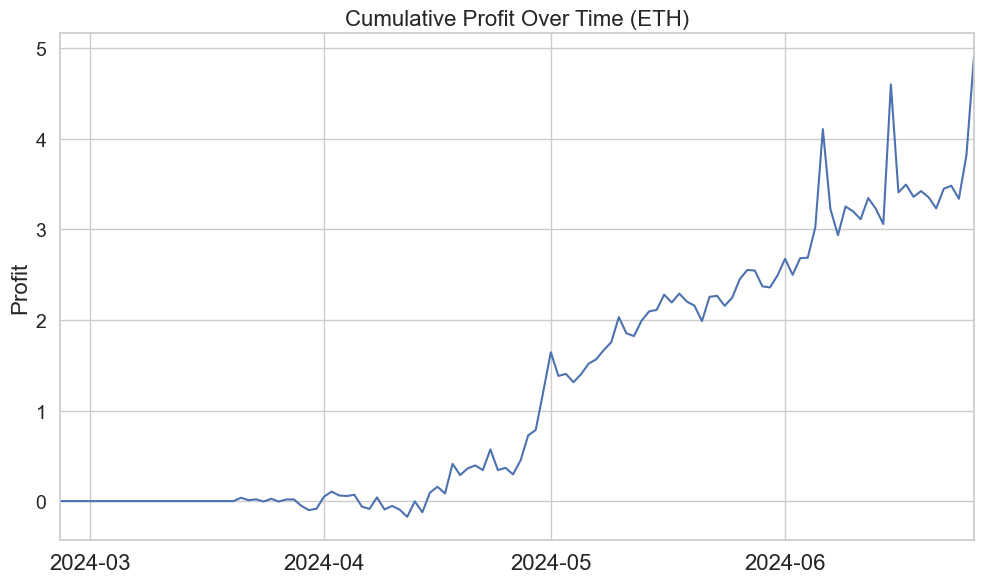

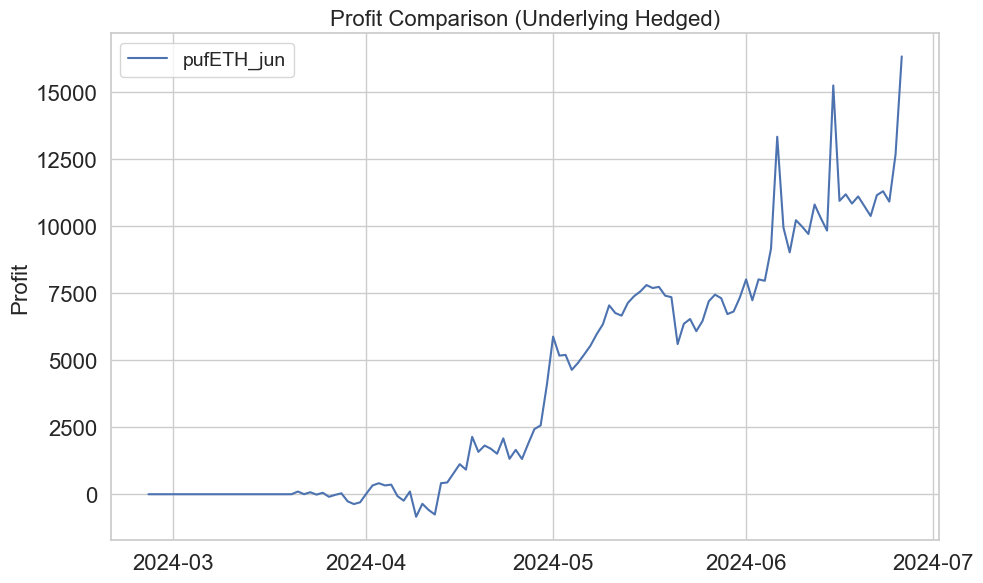

In [43]:
# For this one, you must remove the cumulative_profit = cumulative_profit[:-1] line since it is already removed in the backtest class

class HighFixedYield(Strategy):
    def __init__(self, start_bal=500):
        self.bal = start_bal

    def trade(self, prices_df, current_index, underlying_pos, pt_pos, yt_pos, name=None):
        current_row = prices_df.loc[current_index]
        if current_row['fixed_yield'] > 0.4 and self.bal > 0:
            self.bal -= 1
            return (-1, 1, 0)
        # elif current_row['fixed_yield'] < 0.1:
        #     self.bal += 1
        #     return (1, -1, 0)
        return (0, 0, 0)

assets_strategies = {
    # 'etherfi_jun': {'data': etherfi_eETH_jun_df, 'strategy': HighFixedYield()},
    # 'zircuit_jun': {'data': zircuit_eETH_jun_df, 'strategy': HighFixedYield()},
    # 'pufETH_jun': {'data': pufETH_jun_df, 'strategy': HighFixedYield()},
    # 'uniETH_jun': {'data': uniETH_jun_df, 'strategy': HighFixedYield()},
    # 'rsETH_jun': {'data': rsETH_jun_df, 'strategy': HighFixedYield()}
}
backtest = PendleHedgedBacktest(assets_strategies, isJune=True)
backtest.plot_profit(includeLast=True)

profits_dict = {}

for asset_name, asset_info in assets_strategies.items():
    # Set the current strategy and data in the backtest object
    backtest = PendleBacktest({asset_name: asset_info}, isJune=True)
    # Run the trade method and collect profits
    profits = backtest.trade()
    profits_dict[asset_name] = profits

# Plotting
plt.figure(figsize=(10, 6))
for asset_name, profits in profits_dict.items():
    plt.plot(profits.index, profits, label=asset_name)

plt.title('Profit Comparison (Underlying Hedged)', fontsize=16)
plt.ylabel('Profit', fontsize=16)
plt.legend(loc='upper left', fontsize=14)

# Set x-axis to show dates in a consistent format
plt.gca().xaxis.set_major_locator(mdates.MonthLocator())
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))

plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.tight_layout()

plt.show()

### High Implied APYs

Profit: 4047.71
Sharpe Ratio: 1.88
Sortino Ratio: 1.66
Daily returns: 0.059601465930580654


c:\Python310\lib\site-packages\pandas\core\arraylike.py:396: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


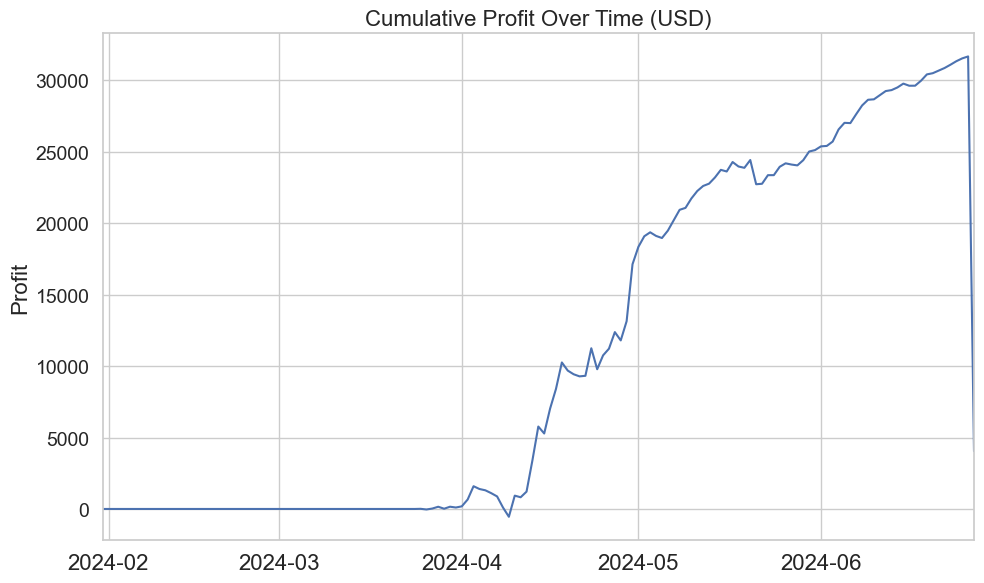

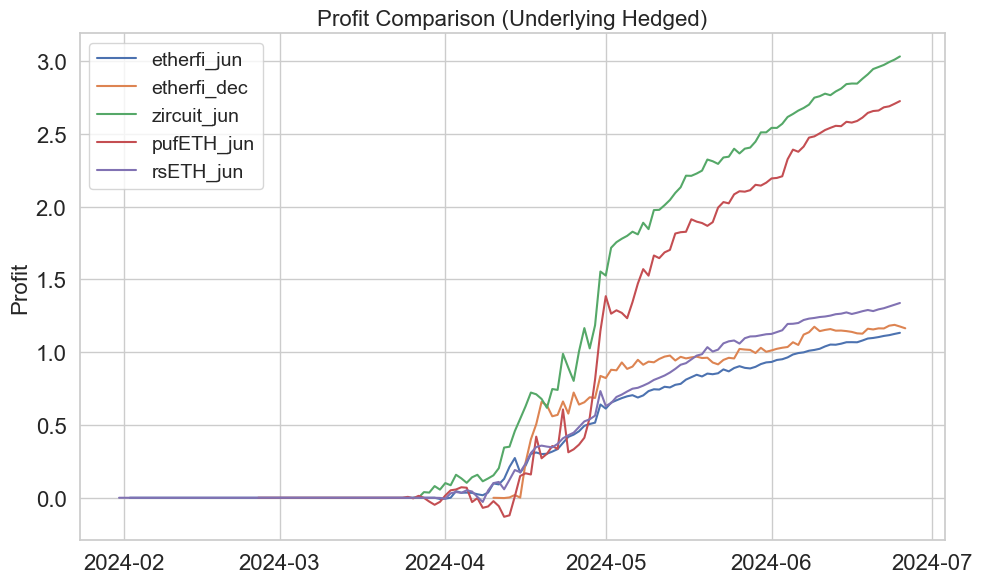

In [37]:
class TooHighImpliedAPY(Strategy):
    def trade(self, prices_df, current_index, underlying_pos, pt_pos, yt_pos, name=None):
        current_row = prices_df.loc[current_index]
        if current_row['implied_apy'] > 0.4:
            return (0, 0, -1)
        return (0, 0, 0)

assets_strategies = {
    'etherfi_jun': {'data': etherfi_eETH_jun_df, 'strategy': TooHighImpliedAPY()},
    'etherfi_dec': {'data': etherfi_eETH_dec_df, 'strategy': TooHighImpliedAPY()},
    'zircuit_jun': {'data': zircuit_eETH_jun_df, 'strategy': TooHighImpliedAPY()},
    'pufETH_jun': {'data': pufETH_jun_df, 'strategy': TooHighImpliedAPY()},
    'rsETH_jun': {'data': rsETH_jun_df, 'strategy': TooHighImpliedAPY()},
}
backtest = PendleBacktest(assets_strategies)
backtest.plot_profit()



profits_dict = {}

for asset_name, asset_info in assets_strategies.items():
    # Set the current strategy and data in the backtest object
    backtest = PendleHedgedBacktest({asset_name: asset_info}, isJune=True)
    # Run the trade method and collect profits
    profits = backtest.trade()
    profits = profits[:-1]
    profits_dict[asset_name] = profits

# Plotting
plt.figure(figsize=(10, 6))
for asset_name, profits in profits_dict.items():
    plt.plot(profits.index, profits, label=asset_name)

plt.title('Profit Comparison (Underlying Hedged)', fontsize=16)
plt.ylabel('Profit', fontsize=16)
plt.legend(loc='upper left', fontsize=14)

# Set x-axis to show dates in a consistent format
plt.gca().xaxis.set_major_locator(mdates.MonthLocator())
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))

plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.tight_layout()


### PT/YT arbitrage

Profit: -1374.62
Sharpe Ratio: nan
Sortino Ratio: nan
Daily returns: nan


c:\Python310\lib\site-packages\pandas\core\arraylike.py:396: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


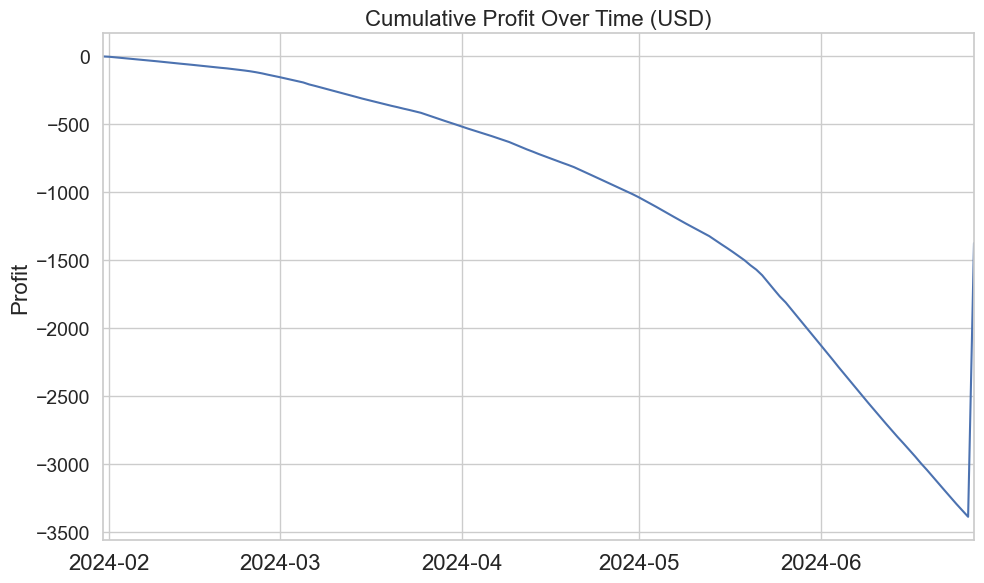

C:\Users\faris\AppData\Local\Temp\ipykernel_18040\896329736.py:44: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colormap = cm.get_cmap('tab20', num_assets)  # Adjust the number of colors as needed


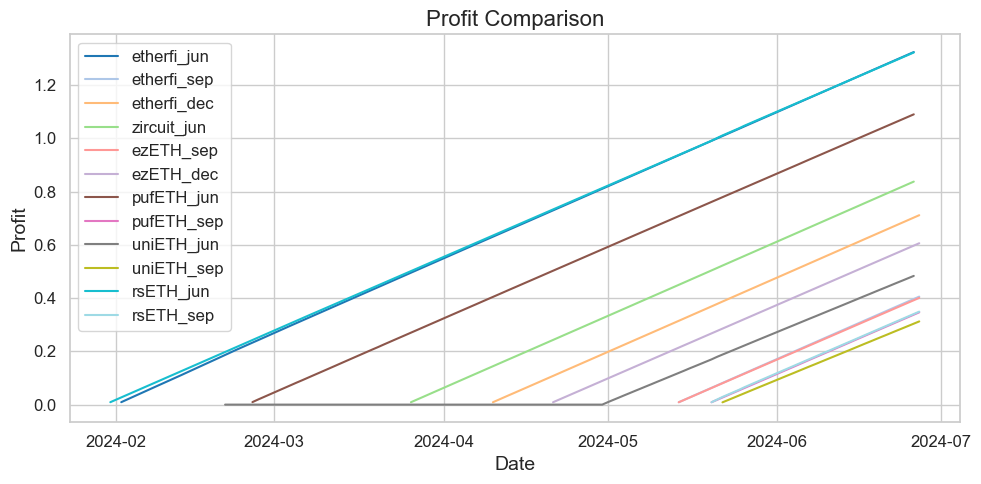

In [38]:
class InvariantArbitrage(Strategy):
    def trade(self, prices_df, current_index, underlying_pos, pt_pos, yt_pos, name=None):
        current_row = prices_df.loc[current_index]
        if current_row['pt_open'] + current_row['yt_open'] > current_row['underlying_open']:
            return (0, 0, 0, True, False) # Make YT + PT - Underlying profit
        elif current_row['pt_open'] + current_row['yt_open'] < current_row['underlying_open']:
            return (0, 0, 0, True, False) # Make Underlying - YT - PT profit
        return (0, 0, 0)

# assets_strategies = {
#     'etherfi_jun': {'data': etherfi_eETH_jun_df, 'strategy': InvariantArbitrage()},
#     'zircuit_jun': {'data': zircuit_eETH_jun_df, 'strategy': InvariantArbitrage()},
#     'pufETH_jun': {'data': pufETH_jun_df, 'strategy': InvariantArbitrage()},
#     'uniETH_jun': {'data': uniETH_jun_df, 'strategy': InvariantArbitrage()},
#     'rsETH_jun': {'data': rsETH_jun_df, 'strategy': InvariantArbitrage()}
# }
assets_strategies = apply_strategy_to_all(InvariantArbitrage())
backtest = PendleBacktest(assets_strategies, isJune=True)
backtest.plot_profit()

profits_dict = {}

for asset_name, asset_info in assets_strategies.items():
    # Set the current strategy and data in the backtest object
    backtest = PendleHedgedBacktest({asset_name: asset_info}, isJune=True)
    # Run the trade method and collect profits
    profits = backtest.trade()
    profits_dict[asset_name] = profits

# Plotting
# Define a list of colors
colors = ['b', 'g', 'r', 'c', 'm', 'y', 'k']

# If you have more assets than colors, use a colormap
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.cm as cm

# Assuming profits_dict is defined and populated as in your snippet
num_assets = len(profits_dict)

# Use a colormap with a wide range of distinct colors
# For more than 20 lines, you might combine colormaps or use them with variations
colormap = cm.get_cmap('tab20', num_assets)  # Adjust the number of colors as needed

colors = [colormap(i) for i in range(num_assets)]

plt.figure(figsize=(10, 5))

# Use enumerate to get both the index and the asset name
for i, (asset_name, profits) in enumerate(profits_dict.items()):
    plt.plot(profits.index, profits, label=asset_name, color=colors[i])

plt.title('Profit Comparison', fontsize=16)
plt.xlabel('Date', fontsize=14)
plt.ylabel('Profit', fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.legend(fontsize=12, loc='best')
plt.tight_layout()
plt.show()

## TVL Factor

Profit: 2005.94
Sharpe Ratio: 1.12
Sortino Ratio: 1.23
Daily returns: 0.024592647587028425


c:\Python310\lib\site-packages\pandas\core\arraylike.py:396: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


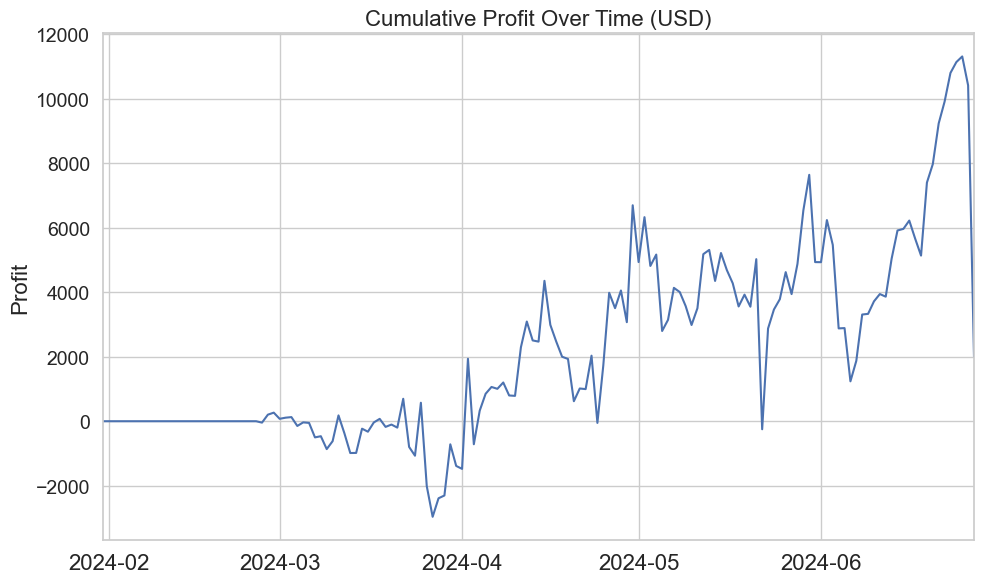

Profit: 18991.44
Sharpe Ratio: 4.64
Sortino Ratio: 8.08
Daily returns: 0.09438944050917601


c:\Python310\lib\site-packages\pandas\core\arraylike.py:396: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


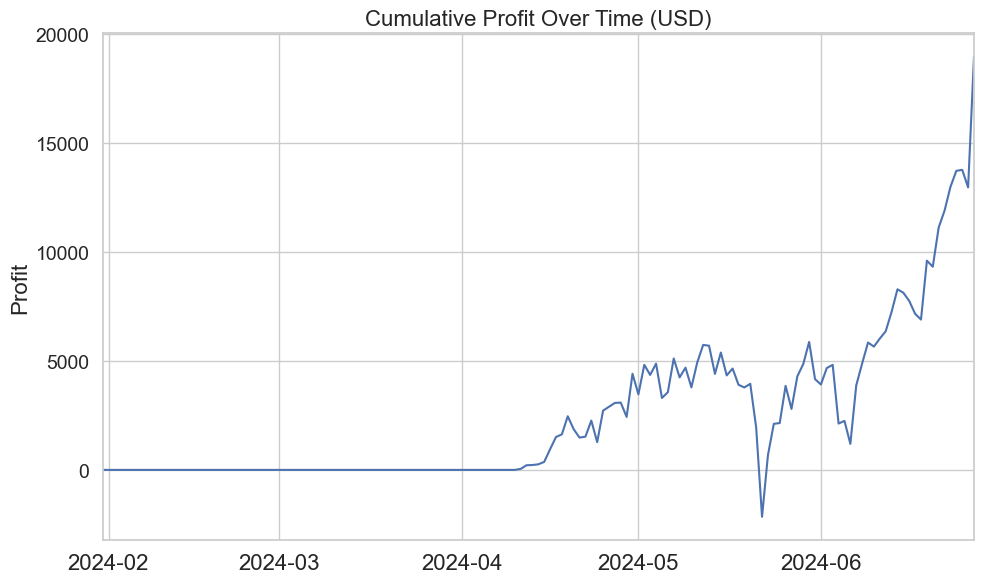

Profit: -11173.27
Sharpe Ratio: 6.20
Sortino Ratio: 5.88
Daily returns: 0.09912529443466947


c:\Python310\lib\site-packages\pandas\core\arraylike.py:396: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


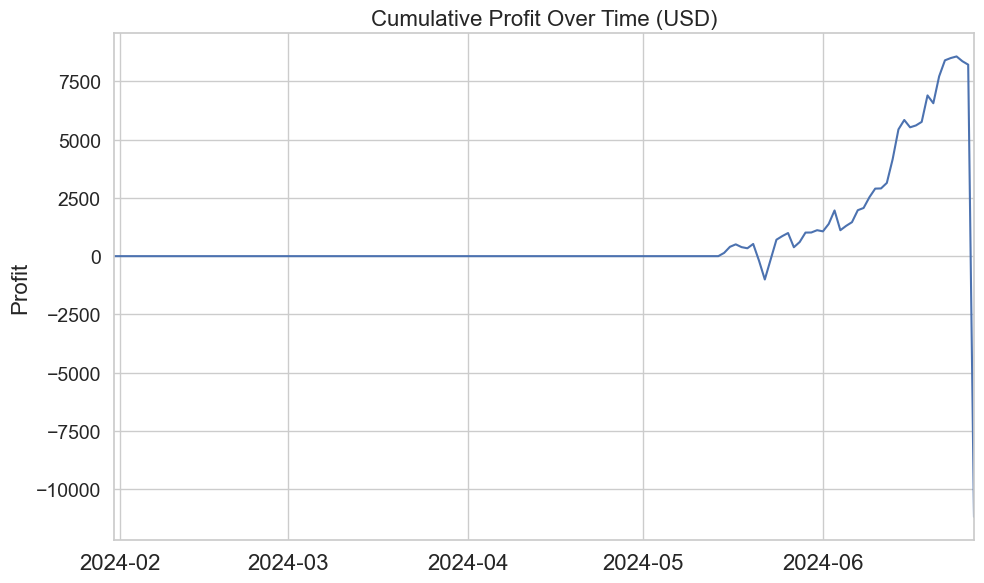

In [39]:
class TVLBasketStrategy(Strategy):
    def __init__(self, trading_signals):
        self.trading_signals = trading_signals

    def trade(self, df, current_index, underlying_pos, pt_pos, yt_pos, name):
        # Return the signal for the specific token at the given index
        try:
            if current_index in self.trading_signals.index:
                value = self.trading_signals.at[current_index, name]
                return (0, -value, 0)
            return (0, 0, 0)
        except:
            return (0, 0, 0)




tvl_df = pd.DataFrame(get_data_dict('tvl'))
volatility_df = pd.DataFrame(get_data_dict('30d_volatility'))
tvl_signals = generate_feature_and_vol_signals(tvl_df, volatility_df)
assets_strategies = apply_strategy_to_all(TVLBasketStrategy(tvl_signals))

# def generate_tvl_signals(tvl_df, n=2):
#     signals_df = pd.DataFrame(index=tvl_df.index)
#     for date, tvls in tvl_df.iterrows():
#         # Drop NaN values in TVL to ensure proper sorting
#         tvls = tvls.dropna()
#         sorted_tokens = tvls.sort_values(ascending=False).index.tolist()
#         # Ensure there are enough tokens to assign signals
#         if len(sorted_tokens) >= 2 * n:
#             for token in sorted_tokens[:n]:  # Buy signal for top n
#                 signals_df.at[date, token] = 1
#             for token in sorted_tokens[-n:]:  # Short signal for bottom n
#                 signals_df.at[date, token] = -1
#     return signals_df.fillna(0)


# trading_signals = generate_feature_and_vol_signals(tvl_df, volatility_df, n=2)
# assets_strategies = apply_strategy_to_all(TVLBasketStrategy(trading_signals))
# backtest = PendleBacktest(assets_strategies, isJune=False)
# backtest.plot_profit()


profits_dict = {}

# Loop over the desired values of n
# for n in [2, 3, 4]:
#     # Generate trading signals
#     trading_signals = generate_feature_and_vol_signals(tvl_df, volatility_df, n=n)

#     # Apply strategy to all assets
#     assets_strategies = apply_strategy_to_all(TVLBasketStrategy(trading_signals))

#     # Run the backtest
#     backtest = PendleBacktest(assets_strategies, isJune=False)

#     # Store the profits in the dictionary
#     profits = backtest.trade()
#     profits = profits[:-1]
#     profits_dict[f'n={n}'] = profits

# # Plot all profits on a single graph
# plt.figure(figsize=(10, 4))
# for label, profits in profits_dict.items():
#     plt.plot(profits.index, profits, label=label)

# plt.title('TVL Factor Strategy for Different n Values', fontsize=16)
# plt.ylabel('Profit', fontsize=16)
# plt.legend(loc='upper left', fontsize=14)
# plt.xticks(fontsize=16)
# plt.yticks(fontsize=16)
# plt.tight_layout()
# plt.show()

for n in [2, 3, 4]:
    trading_signals = generate_feature_and_vol_signals(tvl_df, volatility_df, n=n)
    assets_strategies = apply_strategy_to_all(TVLBasketStrategy(trading_signals))
    backtest = PendleBacktest(assets_strategies, isJune=False)
    backtest.plot_profit()

Profit: 2005.94
Sharpe Ratio: 1.12
Sortino Ratio: 1.23
Daily returns: 0.024592647587028425


c:\Python310\lib\site-packages\pandas\core\arraylike.py:396: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


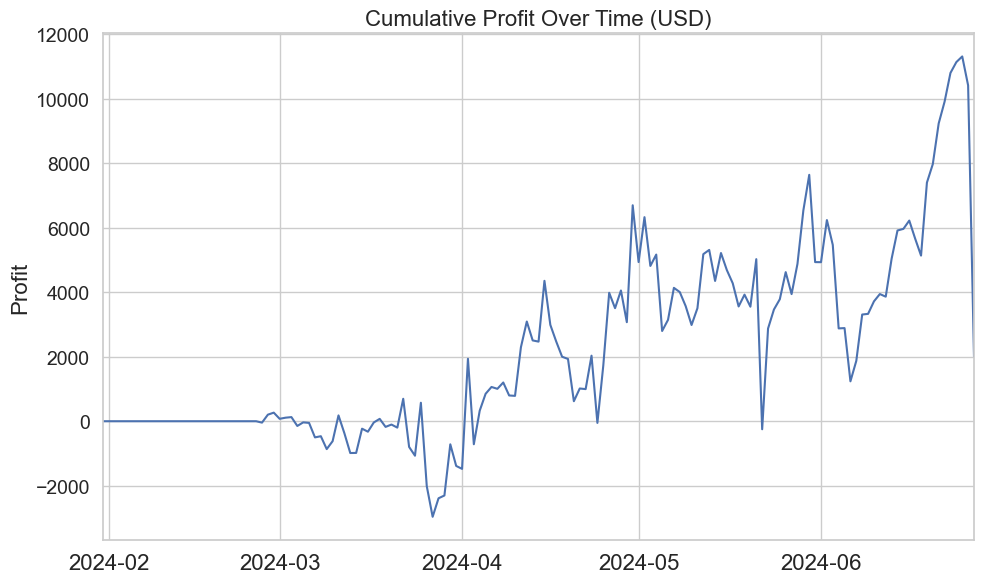

Profit: 18991.44
Sharpe Ratio: 4.64
Sortino Ratio: 8.08
Daily returns: 0.09438944050917601


c:\Python310\lib\site-packages\pandas\core\arraylike.py:396: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


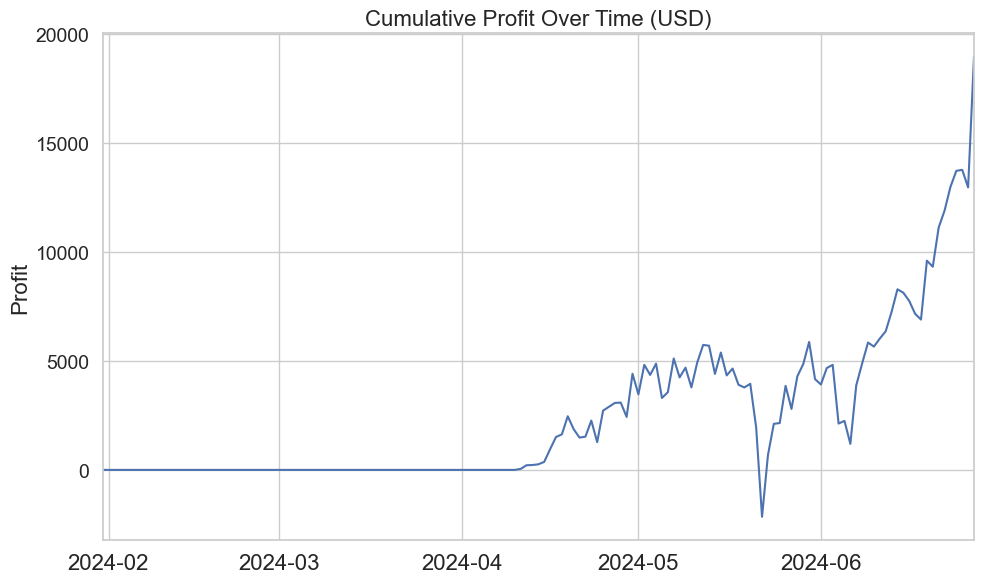

Profit: -11173.27
Sharpe Ratio: 6.20
Sortino Ratio: 5.88
Daily returns: 0.09912529443466947


c:\Python310\lib\site-packages\pandas\core\arraylike.py:396: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


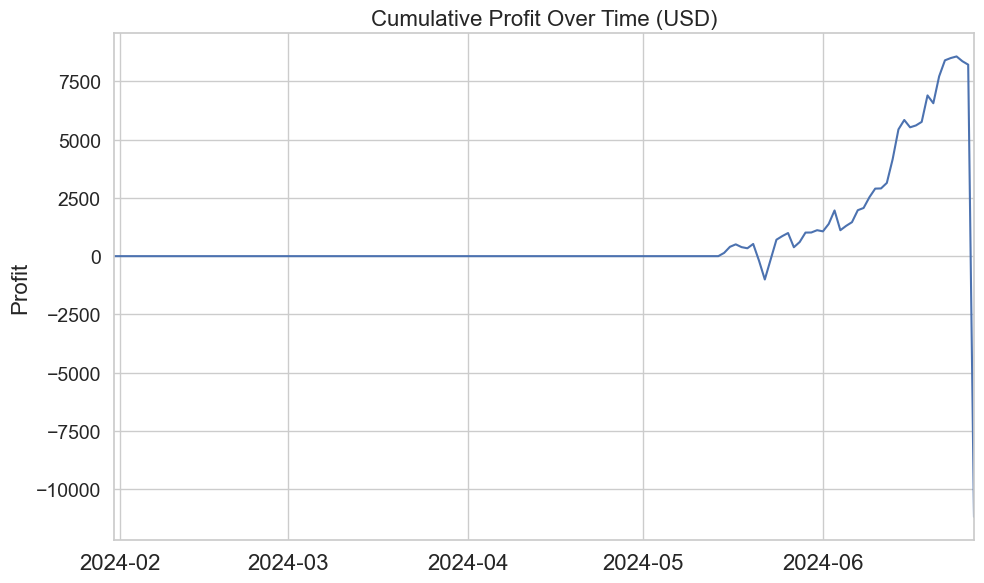

In [40]:
class TVLBasketStrategy(Strategy):
    def __init__(self, trading_signals):
        self.trading_signals = trading_signals

    def trade(self, df, current_index, underlying_pos, pt_pos, yt_pos, name):
        # Return the signal for the specific token at the given index
        try:
            if current_index in self.trading_signals.index:
                value = self.trading_signals.at[current_index, name]
                return (0, -value, 0)
            return (0, 0, 0)
        except:
            return (0, 0, 0)

def get_data_dict(col_name):
    return {
        'etherfi_jun': etherfi_eETH_jun_df[col_name],
        'etherfi_sep': etherfi_eETH_sep_df[col_name],
        'etherfi_dec': etherfi_eETH_dec_df[col_name],
        'zircuit_jun': zircuit_eETH_jun_df[col_name],
        'ezETH_sep': ezETH_sep_df[col_name],
        'ezETH_dec': ezETH_dec_df[col_name],
        'pufETH_jun': pufETH_jun_df[col_name],
        'pufETH_sep': pufETH_sep_df[col_name],
        'uniETH_jun': uniETH_jun_df[col_name],
        'uniETH_sep': uniETH_sep_df[col_name],
        'rsETH_jun': rsETH_jun_df[col_name],
        'rsETH_sep': rsETH_sep_df[col_name]
    }



tvl_df = pd.DataFrame(get_data_dict('tvl'))
volatility_df = pd.DataFrame(get_data_dict('30d_volatility'))
tvl_signals = generate_feature_and_vol_signals(tvl_df, volatility_df)
assets_strategies = apply_strategy_to_all(TVLBasketStrategy(tvl_signals))

# def generate_tvl_signals(tvl_df, n=2):
#     signals_df = pd.DataFrame(index=tvl_df.index)
#     for date, tvls in tvl_df.iterrows():
#         # Drop NaN values in TVL to ensure proper sorting
#         tvls = tvls.dropna()
#         sorted_tokens = tvls.sort_values(ascending=False).index.tolist()
#         # Ensure there are enough tokens to assign signals
#         if len(sorted_tokens) >= 2 * n:
#             for token in sorted_tokens[:n]:  # Buy signal for top n
#                 signals_df.at[date, token] = 1
#             for token in sorted_tokens[-n:]:  # Short signal for bottom n
#                 signals_df.at[date, token] = -1
#     return signals_df.fillna(0)


# trading_signals = generate_feature_and_vol_signals(tvl_df, volatility_df, n=2)
# assets_strategies = apply_strategy_to_all(TVLBasketStrategy(trading_signals))
# backtest = PendleBacktest(assets_strategies, isJune=False)
# backtest.plot_profit()


profits_dict = {}

# Loop over the desired values of n
# for n in [2, 3, 4]:
#     # Generate trading signals
#     trading_signals = generate_feature_and_vol_signals(tvl_df, volatility_df, n=n)

#     # Apply strategy to all assets
#     assets_strategies = apply_strategy_to_all(TVLBasketStrategy(trading_signals))

#     # Run the backtest
#     backtest = PendleBacktest(assets_strategies, isJune=False)

#     # Store the profits in the dictionary
#     profits = backtest.trade()
#     profits = profits[:-1]
#     profits_dict[f'n={n}'] = profits

# # Plot all profits on a single graph
# plt.figure(figsize=(10, 4))
# for label, profits in profits_dict.items():
#     plt.plot(profits.index, profits, label=label)

# plt.title('TVL Factor Strategy for Different n Values', fontsize=16)
# plt.ylabel('Profit', fontsize=16)
# plt.legend(loc='upper left', fontsize=14)
# plt.xticks(fontsize=16)
# plt.yticks(fontsize=16)
# plt.tight_layout()
# plt.show()

for n in [2, 3, 4]:
    trading_signals = generate_feature_and_vol_signals(tvl_df, volatility_df, n=n)
    assets_strategies = apply_strategy_to_all(TVLBasketStrategy(trading_signals))
    backtest = PendleBacktest(assets_strategies, isJune=False)
    backtest.plot_profit()

## Expected Base Yield Factor

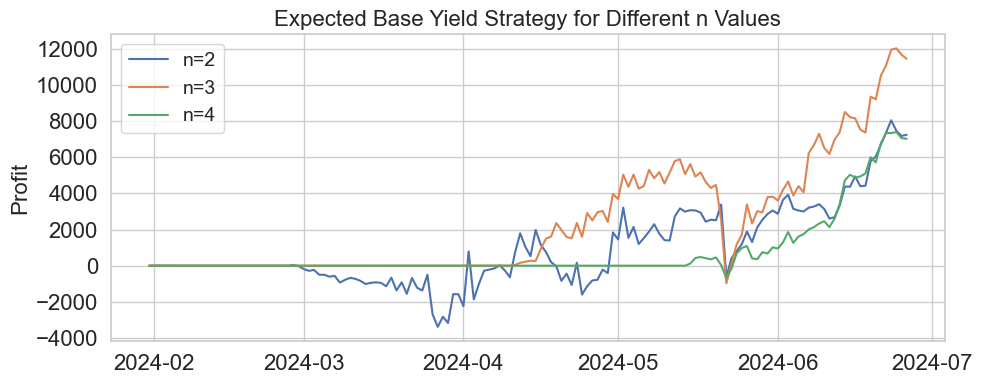

Profit: 9398.80
Sharpe Ratio: 1.85
Sortino Ratio: 2.35
Daily returns: 0.038745469960963556


c:\Python310\lib\site-packages\pandas\core\arraylike.py:396: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


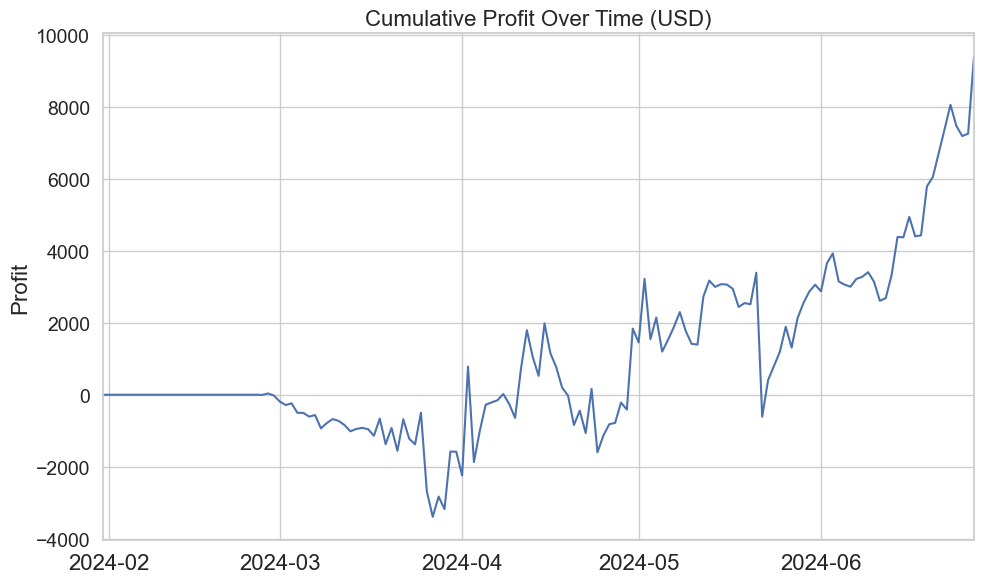

Profit: 24552.04
Sharpe Ratio: 4.93
Sortino Ratio: 31.74
Daily returns: 0.20757796872417267


c:\Python310\lib\site-packages\pandas\core\arraylike.py:396: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


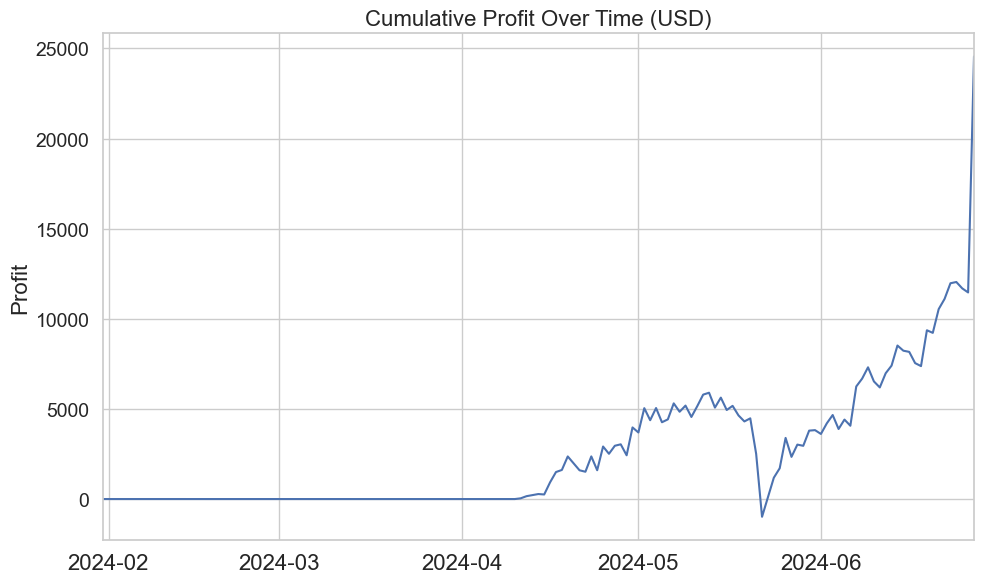

Profit: 12929.58
Sharpe Ratio: 3.24
Sortino Ratio: 4.43
Daily returns: 0.1689588611328161


c:\Python310\lib\site-packages\pandas\core\arraylike.py:396: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


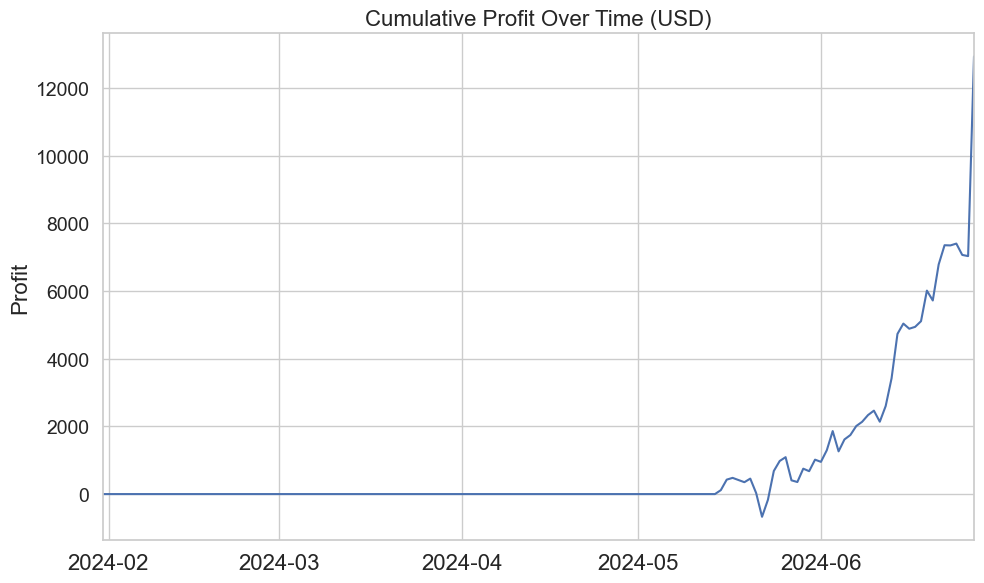

In [41]:
class ExpectedBaseYield(Strategy):
    def __init__(self, trading_signals):
        self.trading_signals = trading_signals

    def trade(self, df, current_index, underlying_pos, pt_pos, yt_pos, name):
        # Return the signal for the specific token at the given index
        try:
            if current_index in self.trading_signals.index:
                value = self.trading_signals.at[current_index, name]
                return (0, 0, value)
            return (0, 0, 0)
        except:
            return (0, 0, 0)

def get_data_dict(col_name):
    return {
        'etherfi_jun': etherfi_eETH_jun_df[col_name],
        'etherfi_sep': etherfi_eETH_sep_df[col_name],
        'etherfi_dec': etherfi_eETH_dec_df[col_name],
        'zircuit_jun': zircuit_eETH_jun_df[col_name],
        'ezETH_sep': ezETH_sep_df[col_name],
        'ezETH_dec': ezETH_dec_df[col_name],
        'pufETH_jun': pufETH_jun_df[col_name],
        'pufETH_sep': pufETH_sep_df[col_name],
        'uniETH_jun': uniETH_jun_df[col_name],
        'uniETH_sep': uniETH_sep_df[col_name],
        'rsETH_jun': rsETH_jun_df[col_name],
        'rsETH_sep': rsETH_sep_df[col_name]
    }

price_df = pd.DataFrame(get_data_dict('underlying_open'))
volatility_df = pd.DataFrame(get_data_dict('30d_volatility'))
price_signals = generate_feature_and_vol_signals(price_df, volatility_df)
assets_strategies = apply_strategy_to_all(ExpectedBaseYield(price_signals))

profits_dict = {}

# Loop over the desired values of n
for n in [2, 3, 4]:
    # Generate trading signals
    trading_signals = generate_feature_and_vol_signals(tvl_df, volatility_df, n=n)

    # Apply strategy to all assets
    assets_strategies = apply_strategy_to_all(ExpectedBaseYield(trading_signals))

    # Run the backtest
    backtest = PendleBacktest(assets_strategies, isJune=False)

    # Store the profits in the dictionary
    profits = backtest.trade()
    profits = profits[:-1]
    profits_dict[f'n={n}'] = profits

# Plot all profits on a single graph
plt.figure(figsize=(10, 4))
for label, profits in profits_dict.items():
    plt.plot(profits.index, profits, label=label)

plt.title('Expected Base Yield Strategy for Different n Values', fontsize=16)
plt.ylabel('Profit', fontsize=16)
plt.legend(loc='upper left', fontsize=14)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.tight_layout()
plt.show()

for n in [2, 3, 4]:
    trading_signals = generate_feature_and_vol_signals(tvl_df, volatility_df, n=n)
    assets_strategies = apply_strategy_to_all(ExpectedBaseYield(trading_signals))
    backtest = PendleBacktest(assets_strategies, isJune=False)
    backtest.plot_profit()